In [5]:
import numpy as np
import pandas as pd
import torch
import pickle
import matplotlib.pyplot as plt
from lpne.models import DcsfaNmf
import os, sys
from scipy.io import loadmat

MODEL_FILE = "/hpc/home/mk423/Anxiety/FullDataWork/Models/Final_mt_Model_500_epochs.pt"
DATA_PATH = "/work/mk423/Anxiety/FG_Drug_Data.mat"
CLASS_DATA_PATH = "/work/mk423/Anxiety/FG-7142/ClassData/"
PROJECT_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Projections/"
FIGURE_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Figures/"
LPNE_PATH = "/work/mk423/lpne-data-analysis"
sys.path.append(LPNE_PATH)

import data_tools

model = torch.load(MODEL_FILE,map_location="cpu")
model.device="cpu"

feature_list = ["X_psd","X_coh","X_gc"]
feature_weights = [10,1,1]

In [4]:
X_psd,X_coh,X_gc,labels = data_tools.load_data(DATA_PATH,feature_list=["power","coherence","granger"])

version saveFeatures_1.2 used to calcuate power features
version saveFeatures_1.2 used to calcuate coherence features
version saveFeatures_1.2 used to calcuate granger features
Version preprocessData_1.0 of preprocessing used
Make sure feature versions listed above match those used for any other dataset in the same project


/work/mk423/lpne-data-analysis/data_tools.py:144: UserWarning: Raw Granger causality values loaded; if you want exponentiated or capped features, you must do that yourself
  warnings.warn("Raw Granger causality values loaded; if you want exponentiated or capped features, you must do that yourself")


In [37]:
X = np.hstack([X_psd*10,X_coh,X_gc])
y_mouse = np.array(labels['windows']['mouse'])
y_expDate = np.array(labels['windows']['expDate'])
y_time = np.array(labels['windows']['time'])
y_drug = np.zeros(y_mouse.shape[0])
s = model.project(X)
coeffs = model.classifier[0].weight[0].detach().cpu().numpy()
s_agg = s[:,:3] @ coeffs

for mouse in np.unique(y_mouse):
    mouse_mask = y_mouse == mouse
    expDate = np.unique(y_expDate[mouse_mask==1])[0]
    class_file = "_".join([mouse,expDate,"FG7142_ClassData.mat"])
    matDict = loadmat(CLASS_DATA_PATH + class_file)
    y_drug[mouse_mask==1] = matDict['FG'][0][0]


In [26]:
project_dict = {
    "mouse":y_mouse,
    "expDate":y_expDate,
    "time":y_time,
    "drug":y_drug,
    "net 1":s[:,0],
    "net 2":s[:,1],
    "net 3":s[:,2],
    "agg net":s_agg
}

df = pd.DataFrame.from_dict(project_dict)
df.head()
df.to_csv(PROJECT_PATH + "FG7142_Projection.csv",index=False)

In [42]:
mean_mouse_names = []
mean_drug = []
mean_score_net_1 = []
mean_score_net_2 = []
mean_score_net_3 = []
mean_score_agg_net = []

for mouse in np.unique(df["mouse"]):
    mean_mouse_names.append(mouse)
    mean_drug.append(np.unique(df[df["mouse"]==mouse]["drug"])[0])
    mean_score_net_1.append(np.mean(df[df["mouse"]==mouse]["net 1"]))
    mean_score_net_2.append(np.mean(df[df["mouse"]==mouse]["net 2"]))
    mean_score_net_3.append(np.mean(df[df["mouse"]==mouse]["net 3"]))
    mean_score_agg_net.append(np.mean(df[df["mouse"]==mouse]["agg net"]))
    
means_dict = {
    "mouse":mean_mouse_names,
    "drug":mean_drug,
    "mean net 1":mean_score_net_1,
    "mean net 2":mean_score_net_2,
    "mean net 3":mean_score_net_3,
    "mean agg net":mean_score_agg_net,
}

df_means = pd.DataFrame.from_dict(means_dict)
df_means.to_csv(PROJECT_PATH + "FG7142_Mean_Projection.csv",index=False)
df_means.head()

,mouse,drug,mean net 1,mean net 2,mean net 3,mean agg net
0,Mouse0870,1.0,0.092179,0.163996,0.062758,3.682682
1,Mouse0871,0.0,0.093581,0.150841,0.069329,3.481817
2,Mouse0872,0.0,0.075068,0.166169,0.059660,3.549078
3,Mouse0873,1.0,0.074398,0.110006,0.046089,2.596243
4,Mouse1551,0.0,0.081768,0.135745,0.069750,3.114719


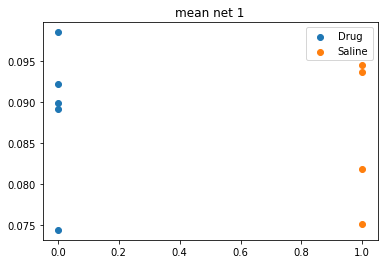

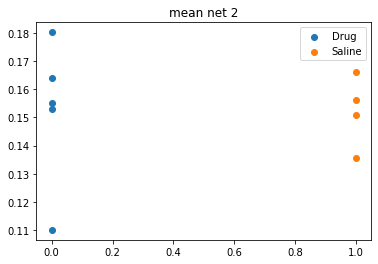

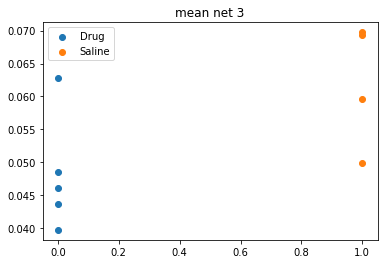

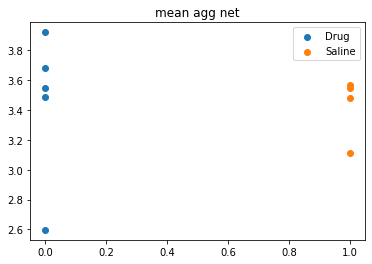

In [41]:
for feature in ["mean net 1","mean net 2","mean net 3","mean agg net"]:
    ya = df_means[df_means["drug"]==1][feature]
    yb = df_means[df_means["drug"]==0][feature]
    
    xa = np.zeros(ya.shape[0])
    xb = np.ones(yb.shape[0])
    
    plt.scatter(xa,ya,label="Drug")
    plt.scatter(xb,yb,label="Saline")
    plt.title("{}".format(feature))
    plt.legend()
    plt.show()